In [4]:
from model import VAE_celeb
from engine import train
import utils

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt

# Get CelebA dataset

In [6]:
batch_size = 64
transform = transforms.Compose([
    transforms.CenterCrop((128, 128)),
    transforms.ToTensor()
    ])

train_dataset = datasets.CelebA (root='./celeb_data', split='train', transform=transform, download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


In [7]:
print('no of images: ', len(train_dataset))
print('img shape: ', train_dataset[0][0].size())
print('label shape: ', train_dataset[0][1].size())

no of images:  162770
img shape:  torch.Size([3, 128, 128])
label shape:  torch.Size([40])


# Model

In [9]:
summary(VAE_celeb(), input_size=(1, 3, 128, 128), col_names=["output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Output Shape              Param #                   Trainable
VAE_celeb                                [1, 21632]                --                        True
├─Sequential: 1-1                        [1, 21632]                --                        True
│    └─Conv2d: 2-1                       [1, 32, 126, 126]         896                       True
│    └─BatchNorm2d: 2-2                  [1, 32, 126, 126]         64                        True
│    └─ReLU: 2-3                         [1, 32, 126, 126]         --                        --
│    └─Dropout2d: 2-4                    [1, 32, 126, 126]         --                        --
│    └─Conv2d: 2-5                       [1, 32, 62, 62]           9,248                     True
│    └─BatchNorm2d: 2-6                  [1, 32, 62, 62]           64                        True
│    └─ReLU: 2-7                         [1, 32, 62, 62]           --                        --
│    └─Dropout2d: 2-8

# Training

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = VAE_celeb().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

cuda


In [1]:
epochs = 80

results = train(model, train_dataloader, optimizer, utils.vae_loss_fn, epochs, device, save_model=True)
results

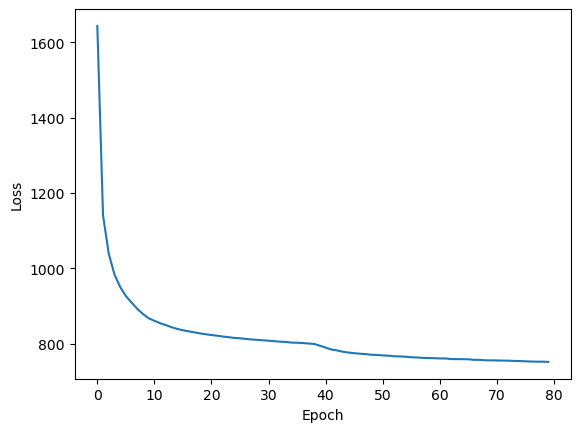

In [106]:
# plot train_loss
plt.plot(results['train_loss'])
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.show()

# Generate Images

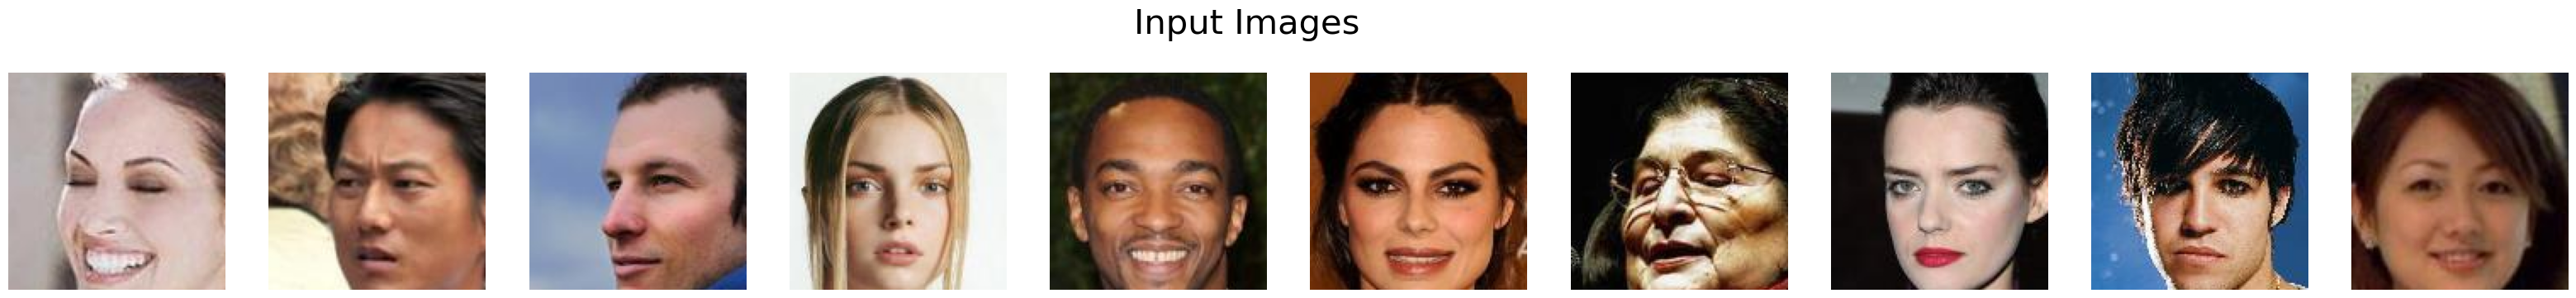

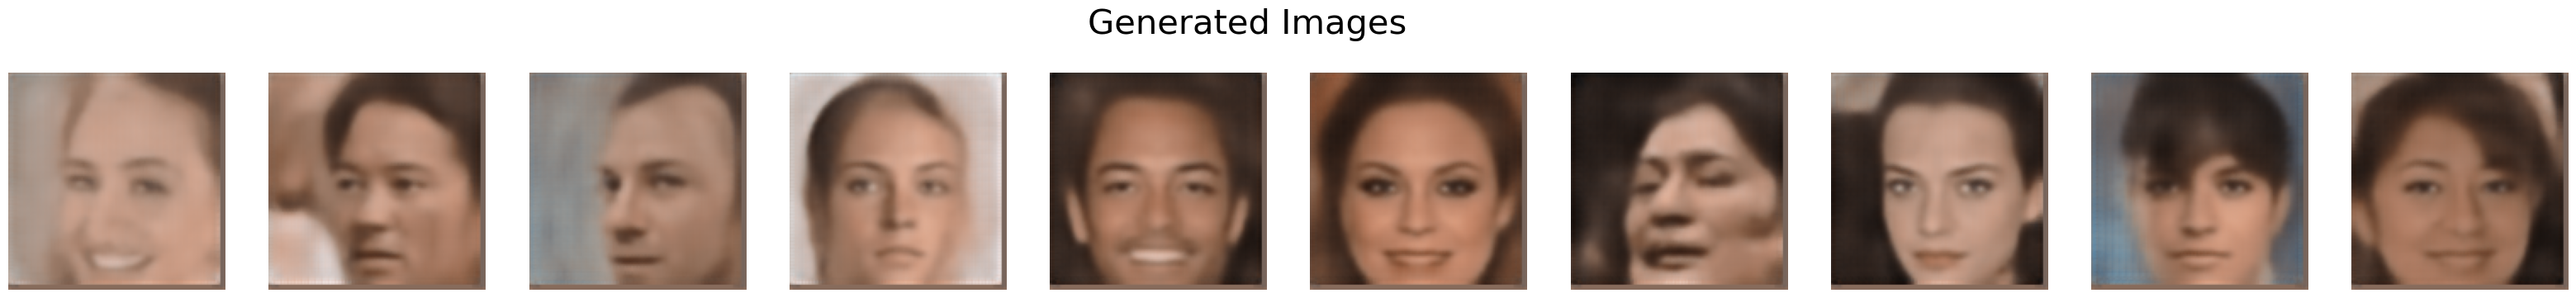

In [33]:
# Get some images
num_images = 10
images = next(iter(train_dataloader))[0][:num_images]

# pass them to the model (Encoder and Decoder) to generate new images that resemble them.
new_images = utils.generate_images_from_vae(model, images, device=device)

utils.plot_imgs(images, ncols=10, title='Input Images')
utils.plot_imgs(new_images, ncols=10, title='Generated Images')

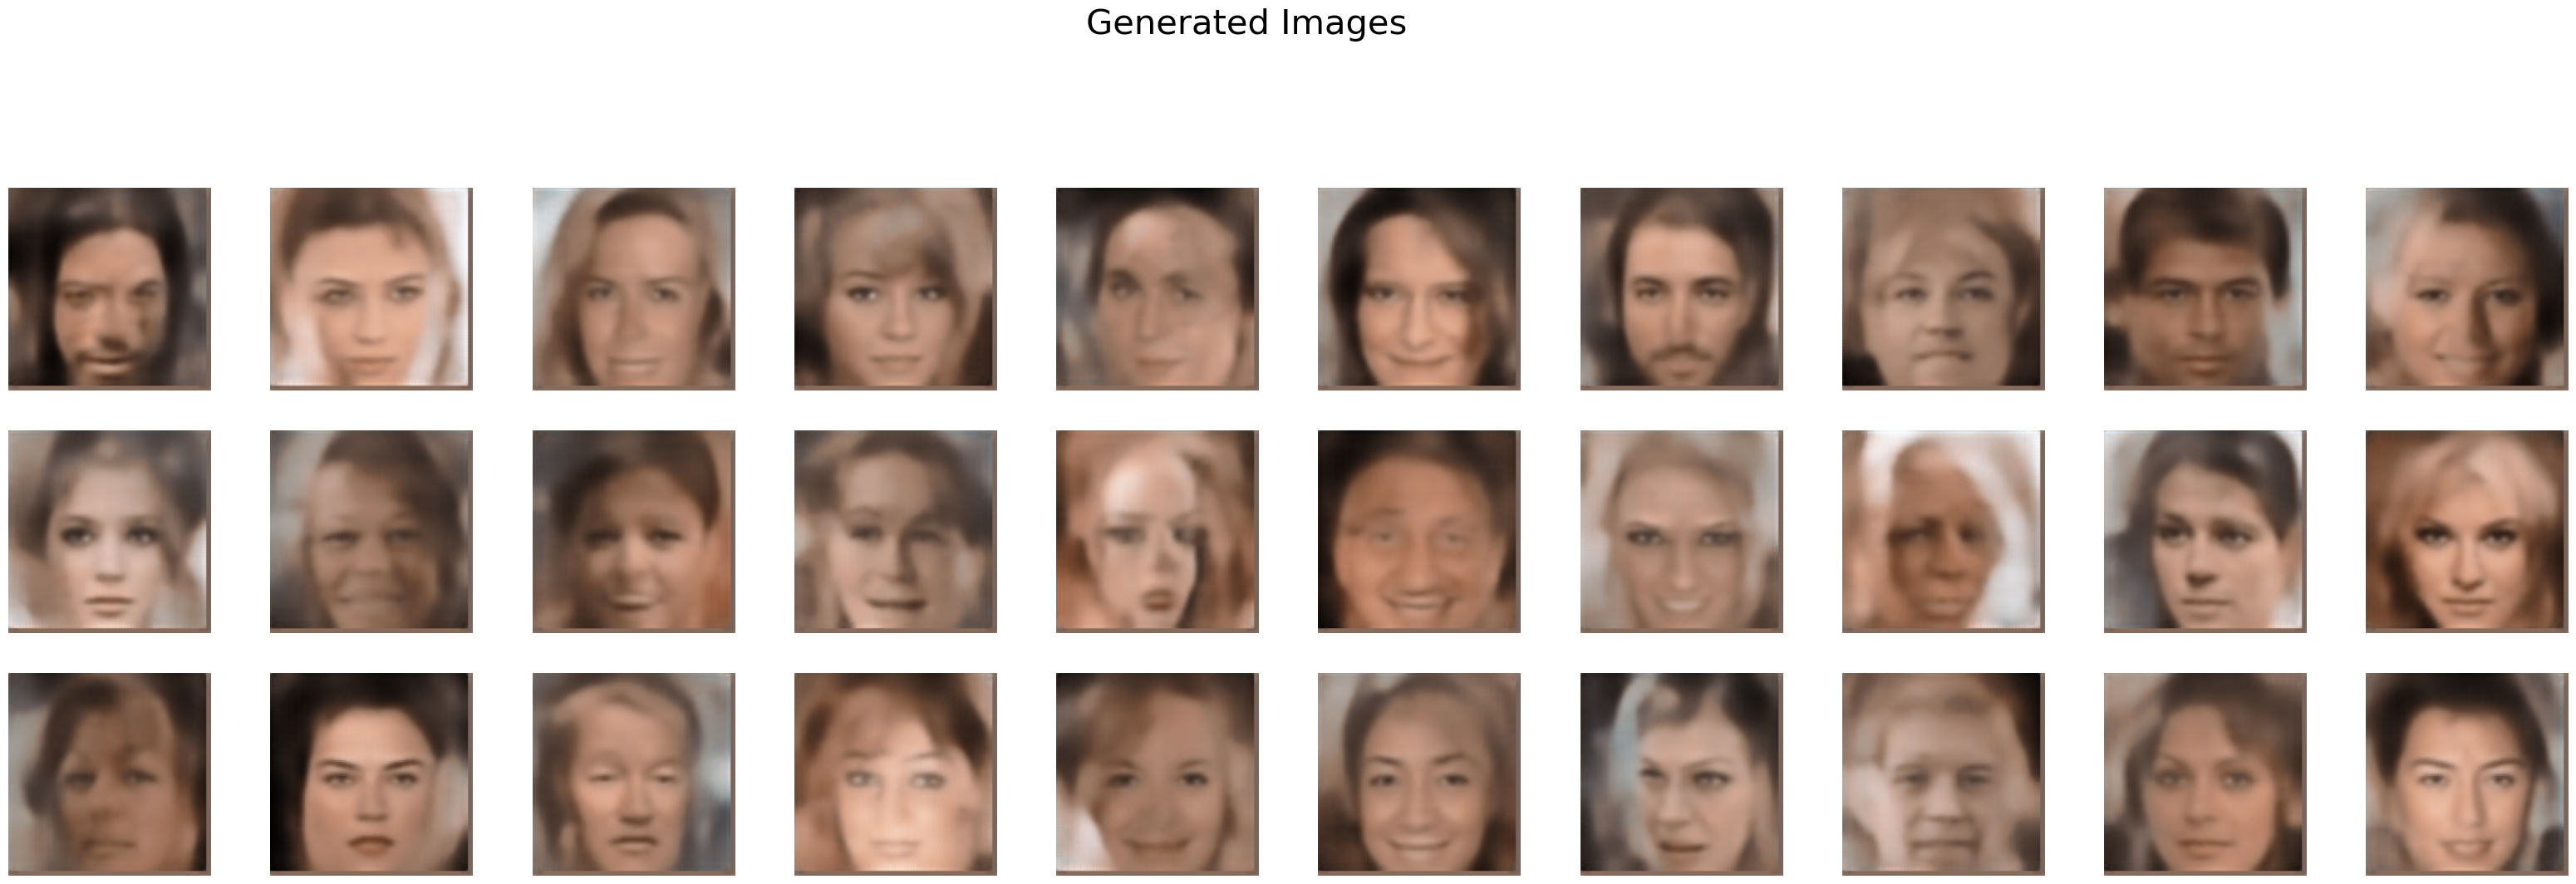

In [34]:
# Sampling a latent vector and pass them to the decoder
new_imgs = utils.generate_images_from_decoder(model, latent_dim=200, num_images=30, device=device)
utils.plot_imgs(new_imgs, ncols=10, title='Generated Images')

# Visualize latent space
- pass all images through the encoder to get a latent vector for each images.
- the model should encode all images to a guassian distribution.

In [35]:
all_embeddings = utils.encode_imaages(model, train_dataloader, device)
all_embeddings.shape

  0%|          | 0/2544 [00:00<?, ?it/s]

torch.Size([162770, 200])

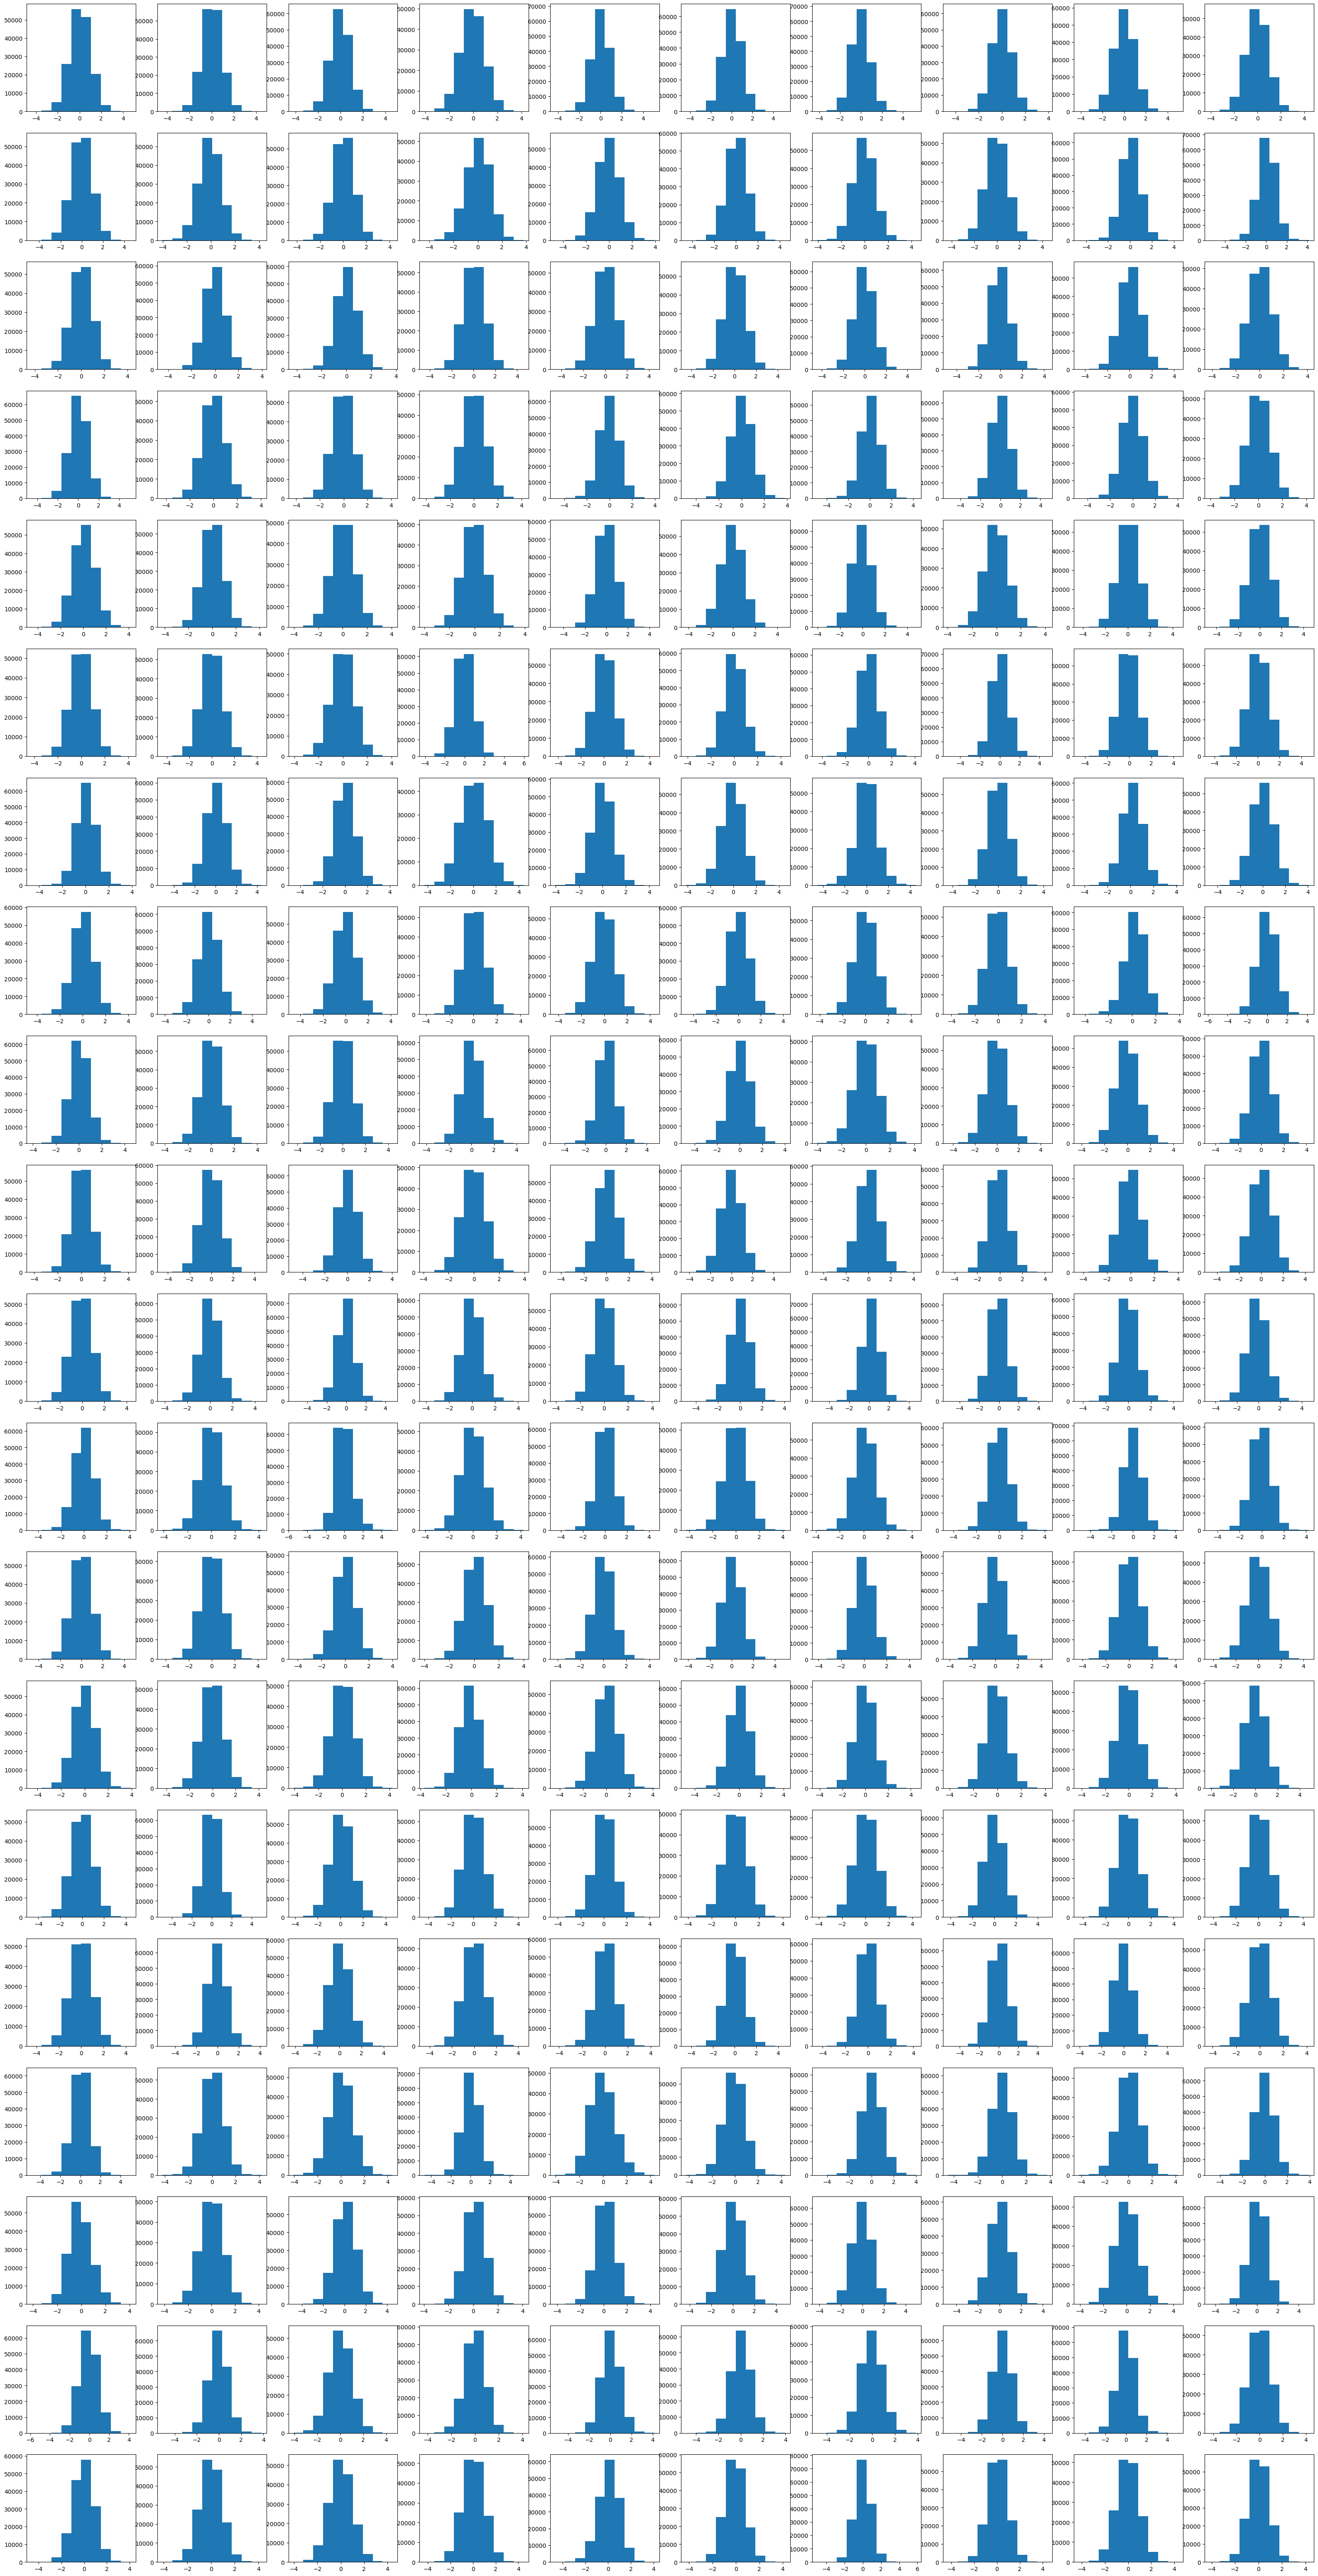

In [37]:
# plot histogram of all latent dimensions.
utils.plot_latent_dims(all_embeddings)

# Image Manipulate - Smiling 
- CelebA dataset has (image, label) where label is a binary vector of length 40 that indicates the presence or absence of 40 different facial attributes.
- we will get all smiling images (images that has smiling attribute=1) and all not smiling images.
- then, averaging all smiling images, all not smiling images and get the difference between the resulted images
- then we will manipulate an image by making it smile more using this equation new_image = orig_img + $\alpha$ * diff or smile less using new_image = orig_img - &alpha; * diff
- Note all of this is done using **original image pixel space** 

In [40]:
# get all attribute names of CelebA dataset
celeba_attr_names = train_dataset.attr_names
print('CelebA attributes: ', celeba_attr_names)

CelebA attributes:  ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', '']


In [41]:
# Get the index of the "smiling" attribute
feature='Smiling'
smiling_attr_index = celeba_attr_names.index(feature)
print('Smiling attribute index', smiling_attr_index)

Smiling attribute index 31


## Divide `train_dataset` into smiling and not smiling datasets and create data_loaders 

In [42]:
# Create a mask where True indicates smiling and False not smiling
mask_indices = train_dataset.attr[:, smiling_attr_index].to(torch.bool)

# Get index for a nonzero value (smiling_indices).
smile_indices = torch.nonzero(mask_indices).squeeze()

# Get index for a nonzero value (not_smiling_indices).
not_smile_indices = torch.nonzero(~mask_indices).squeeze()

# Get subset of dataset corresponds to smiling images
smile_set = torch.utils.data.Subset(train_dataset, smile_indices)

# Get subset of dataset corresponds to non smiling images
not_smile_set = torch.utils.data.Subset(train_dataset, not_smile_indices)

In [43]:
print("first 10 elements of mask indices: \n-> ", mask_indices[:10])
print(f"\nfirst 10 elements of {feature} indices: \n-> ", smile_indices[:10])
print(f"\nfirst 10 elements of non {feature} indices: \n-> ", not_smile_indices[:10])
print(f'\n no. of {feature} images:', len(smile_set))
print(f'\n no. of non {feature} images:', len(not_smile_set))

first 10 elements of mask indices: 
->  tensor([ True,  True, False, False, False, False, False, False,  True, False])

first 10 elements of smile indices: 
->  tensor([ 0,  1,  8, 10, 11, 12, 13, 15, 16, 17])

first 10 elements of not smile indices: 
->  tensor([ 2,  3,  4,  5,  6,  7,  9, 14, 18, 19])

 no. of smiling images: 78080

 no. of not smiling images: 84690


In [44]:
# Create Dataloader
batch_size = 1024
smile_loader = torch.utils.data.DataLoader(smile_set, batch_size=batch_size)

not_smile_loader = torch.utils.data.DataLoader(not_smile_set, batch_size=batch_size)

In [46]:
avg_img_smile = utils.calculate_avg(smile_loader, img_dim=(3, 128, 128), device=device)
avg_img_not_smile = utils.calculate_avg(not_smile_loader, img_dim=(3, 128, 128), device=device)

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

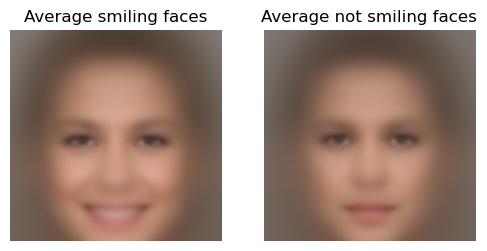

In [47]:
fig = plt.figure(figsize=(6,6))
fig.add_subplot(1, 2, 1)
plt.imshow(avg_img_smile.cpu().permute(1,2,0))
plt.axis(False)
plt.title('Average smiling faces')

fig.add_subplot(1, 2, 2)
plt.imshow(avg_img_not_smile.cpu().permute(1,2,0))
plt.axis(False)
plt.title('Average not smiling faces')
plt.show()

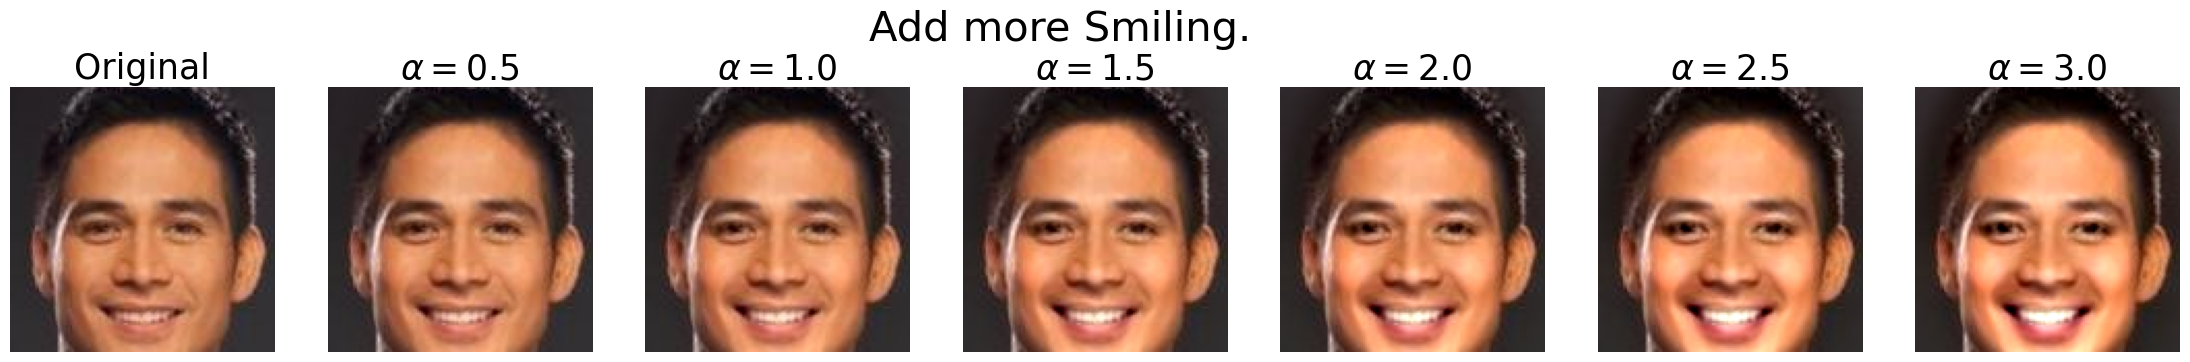

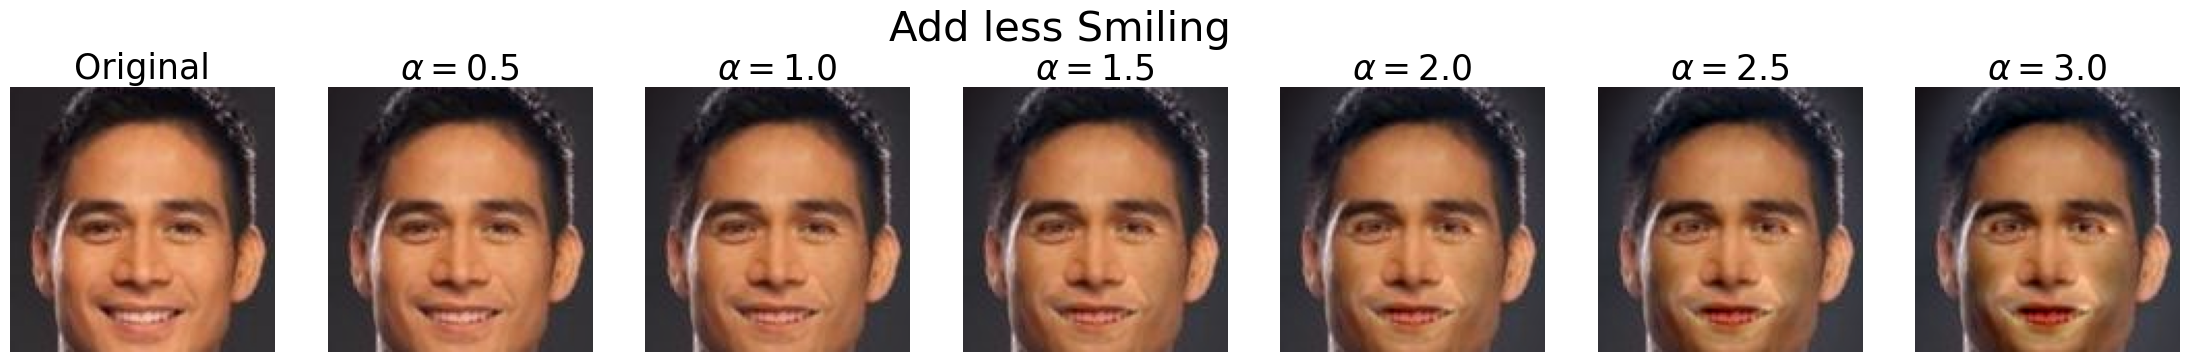

In [96]:
# 4 6 11
alphas = (0., 0.5, 1., 1.5, 2., 2.5, 3.)

# difference between the average of all smiling images and the average all not smiling images 
# img_diff = avg_img_smile - avg_img_not_smile

i = 4  # change this to get different image
more_feature_imgs, less_feature_imgs = utils.manipulate_img(smile_set[i][0], img_diff,
                                                             alphas=alphas)

utils.plot_imgs(more_feature_imgs, nrows=1, ncols=7, title=f'Add more {feature}.', alphas=alphas)
utils.plot_imgs(less_feature_imgs, nrows=1, ncols=7, title=f'Add less {feature}', alphas=alphas)


# Manipulate image in latent space
- first, we will send all smiling images to the encoder to get a latent vector (embedding) for each image.
- then, we will average all the embeddings to get average of all smiling embeddings
- we will do the same thing to get average not smiling embeddings.
- then, we find the difference between the two averages.

In [73]:
# encode all smiling and not smiing images to latent space
smile_embeddings = utils.encode_images(model, smile_loader, device)
not_smile_embeddings = utils.encode_images(model, not_smile_loader, device)

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

In [74]:
smile_embeddings_avg = torch.mean(smile_embeddings, axis=0) 
not_smile_embeddings_avg = torch.mean(not_smile_embeddings, axis=0) 
embeddings_diff = smile_embeddings_avg - not_smile_embeddings_avg

not_smile_embeddings_avg.shape, embeddings_diff.shape

(torch.Size([200]), torch.Size([200]))

In [99]:
# 4 6 11
alphas = (0., 0.5, 1., 1.5, 2., 2.5, 3.)

i = 11  # change this to get different image
more_feature_imgs, less_feature_imgs = utils.manipulate_img(smile_set[i][0], embeddings_diff,
                                                             alphas=alphas,
                                                             latent_space=True,
                                                             model=model,
                                                             device=device)

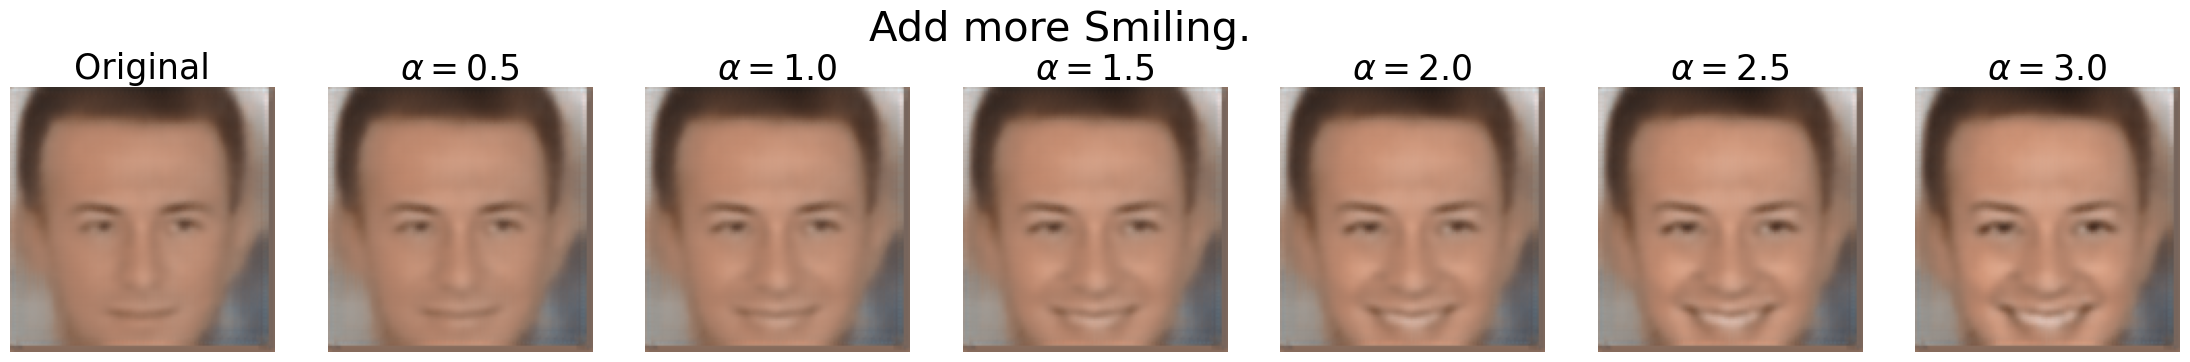

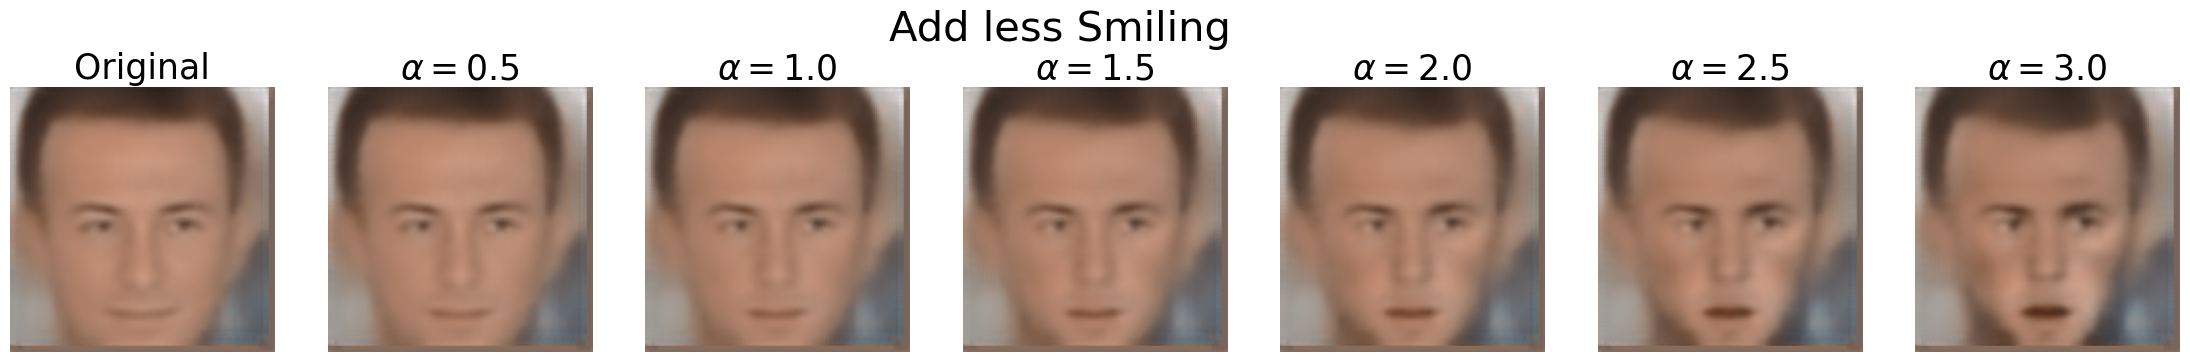

In [100]:
utils.plot_imgs(more_feature_imgs, nrows=1, ncols=7, title=f'Add more {feature}.', alphas=alphas)
utils.plot_imgs(less_feature_imgs, nrows=1, ncols=7, title=f'Add less {feature}\n', alphas=alphas)

# Try different feature (Mustache)

In [1]:
# Get the index of the "smiling" attribute
feature = 'Mustache'
attr_index = celeba_attr_names.index(feature)

# Create a mask where True indicates having a Mustache and False not having a Mustache
mask_indices = train_dataset.attr[:, attr_index].to(torch.bool)

# Get index for a nonzero value (mustache_indices).
mustache_indices = torch.nonzero(mask_indices).squeeze()

# Get index for a nonzero value (not mustache_indices).
not_mustache_indices = torch.nonzero(~mask_indices).squeeze()

# Get subset of dataset corresponds to having a Mustache images
mustache_set = torch.utils.data.Subset(train_dataset, mustache_indices)

# Get subset of dataset corresponds to not having a Mustache images
not_mustache_set = torch.utils.data.Subset(train_dataset, not_mustache_indices)

# Create Dataloader
batch_size = 1024
mustache_loader = torch.utils.data.DataLoader(mustache_set, batch_size=batch_size)

not_mustache_loader = torch.utils.data.DataLoader(not_mustache_set, batch_size=batch_size)

# encode all images to latent space
mustache_embeddings = utils.encode_images(model, mustache_loader, device)
not_mustache_embeddings = utils.encode_images(model, not_mustache_loader, device)

mustache_embeddings_avg = torch.mean(mustache_embeddings, axis=0)
not_mustache_embeddings_avg = torch.mean(not_mustache_embeddings, axis=0)
embeddings_diff = mustache_embeddings_avg - not_mustache_embeddings_avg


alphas = (0., 0.5, 1., 1.5, 2., 2.5, 3.)

i = 0  # change this to get different image
more_feature_imgs, less_feature_imgs = utils.manipulate_img(smile_set[i][0], embeddings_diff,
                                                             alphas=alphas,
                                                             latent_space=True,
                                                             model=model,
                                                             device=device)

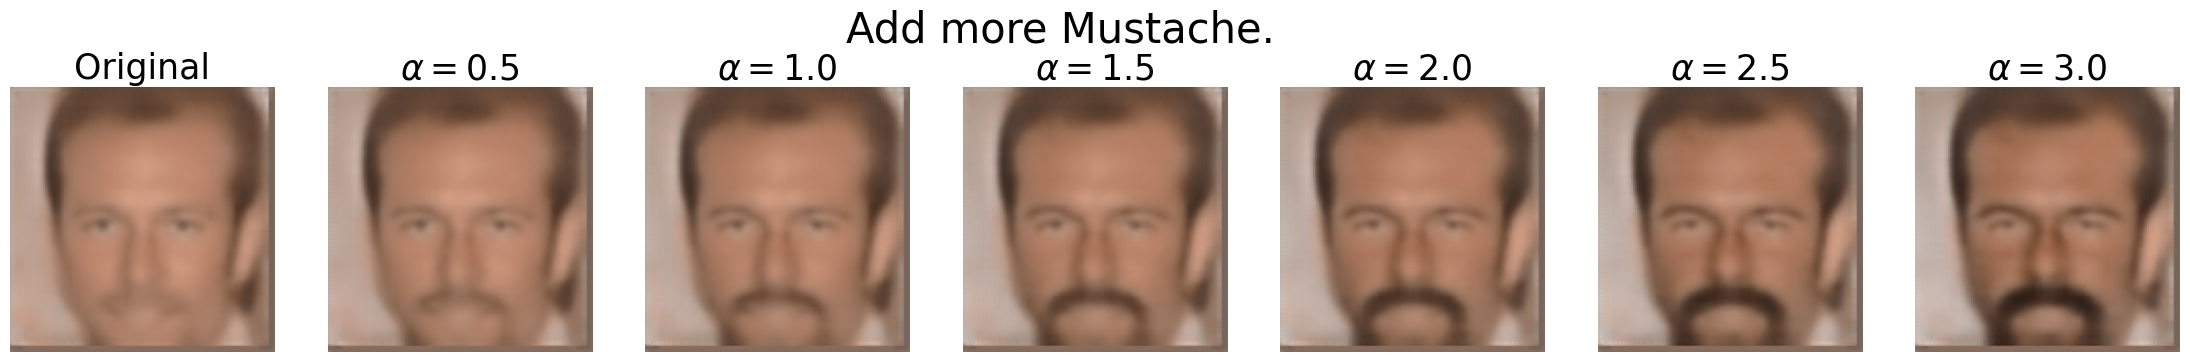

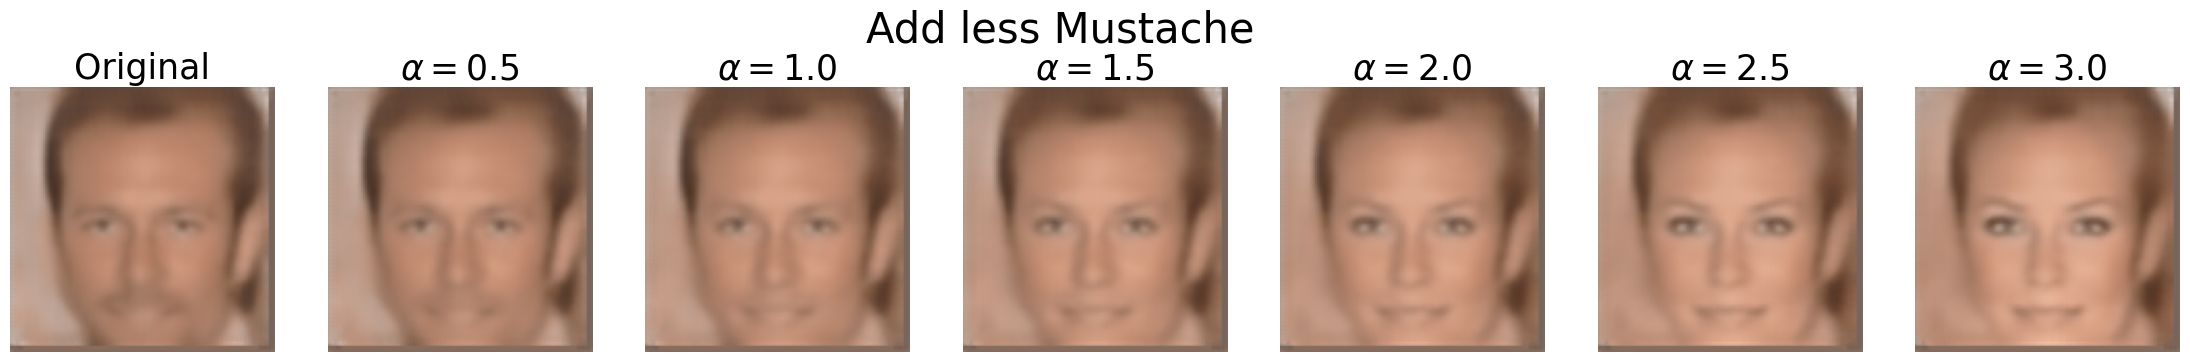

In [ ]:
utils.plot_imgs(more_feature_imgs, nrows=1, ncols=7, title=f'Add more {feature}.', alphas=alphas)
utils.plot_imgs(less_feature_imgs, nrows=1, ncols=7, title=f'Add less {feature}\n', alphas=alphas)